## 3.1 Explorarea Datelor

In [693]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.metrics import classification_report, accuracy_score
from numpy import float32
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

continuous_columns_avc = ['mean_blood_sugar_level', 'body_mass_indicator', 'years_old', 'analysis_results', 'biological_age_index']
discrete_columns_avc = ['cardiovascular_issues', 'job_category', 'sex', 'tobacco_usage', 'high_blood_pressure', 'chaotic_sleep']
target_column_avc = ['cerebrovascular_accident']
remove_columns_avc_regression = ['cerebrovascular_accident']
target_column_avc_algorithms = ['cerebrovascular_accident']
resize_size_avc = 25
batch_size_avc = 14
hidden_units_avc = 1
epochs_no_avc = 30
learning_rate_avc = 0.0005
l2_lambda_avc = 1

continuous_columns_salary = ['fnl', 'hpw', 'gain', 'edu_int', 'years', 'loss', 'prod']
discrete_columns_salary = ['country', 'job', 'work_type', 'partner', 'edu', 'gender', 'race', 'gtype']
target_column_salary = ['money']
remove_columns_salary_regression = ['money_<=50K', 'money_>50K']
target_column_salary_algorithms = ['money_<=50K']
resize_size_salary = 100
batch_size_salary = 512
hidden_units_salary = 4
epochs_no_salary = 100
learning_rate_salary = 0.0005
l2_lambda_salary = 0.25

AVC_DATA = 0
SALARY_DATA = 1
CHOSEN_DATA = 1

In [694]:
def read_csv_data(file):
    return pd.read_csv(file)

def replace_question_signs(df):
    df.replace('?', np.nan, inplace=True)

In [695]:
df_salary_classification_full = read_csv_data("tema2_SalaryPrediction/SalaryPrediction_full.csv")
df_avc_prediction_full = read_csv_data("tema2_AVC/AVC_full.csv")
df_salary_classification_test = read_csv_data("tema2_SalaryPrediction/SalaryPrediction_test.csv")
df_avc_prediction_test = read_csv_data("tema2_AVC/AVC_test.csv")
df_salary_classification_train = read_csv_data("tema2_SalaryPrediction/SalaryPrediction_train.csv")
df_avc_prediction_train = read_csv_data("tema2_AVC/AVC_train.csv")

replace_question_signs(df_salary_classification_full)
replace_question_signs(df_avc_prediction_full)
replace_question_signs(df_salary_classification_test)
replace_question_signs(df_avc_prediction_test)
replace_question_signs(df_salary_classification_train)
replace_question_signs(df_avc_prediction_train)


### 1. Analiza tipului de atribute și a plajei de valori a acestora

#### Atribute numerice continue

In [696]:
import matplotlib.pyplot as plt

def analyze_numeric_attributes(df, continuous_columns):
    numeric_attributes = df[continuous_columns].describe()

    print (numeric_attributes)
    
    for column in continuous_columns:
        plt.close()
        df.boxplot(column)
        plt.show()
        
    

                fnl          hpw          gain      edu_int        years  \
count  9.999000e+03  9199.000000   9999.000000  9999.000000  9999.000000   
mean   1.903529e+05    40.416241    979.853385    14.262026    38.646865   
std    1.060709e+05    12.517356   7003.795382    24.770835    13.745101   
min    1.921400e+04     1.000000      0.000000     1.000000    17.000000   
25%    1.182825e+05    40.000000      0.000000     9.000000    28.000000   
50%    1.784720e+05    40.000000      0.000000    10.000000    37.000000   
75%    2.373110e+05    45.000000      0.000000    13.000000    48.000000   
max    1.455435e+06    99.000000  99999.000000   206.000000    90.000000   

              loss           prod  
count  9999.000000    9999.000000  
mean     84.111411    2014.927593  
std     394.035484   14007.604496  
min       0.000000     -28.000000  
25%       0.000000      42.000000  
50%       0.000000      57.000000  
75%       0.000000      77.000000  
max    3770.000000  200125.

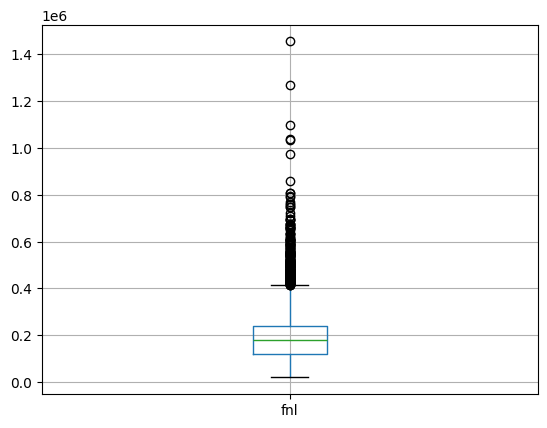

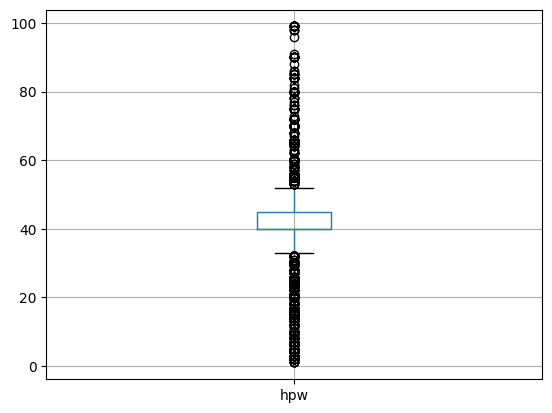

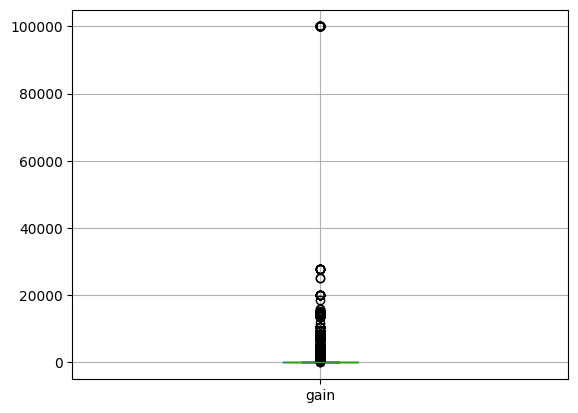

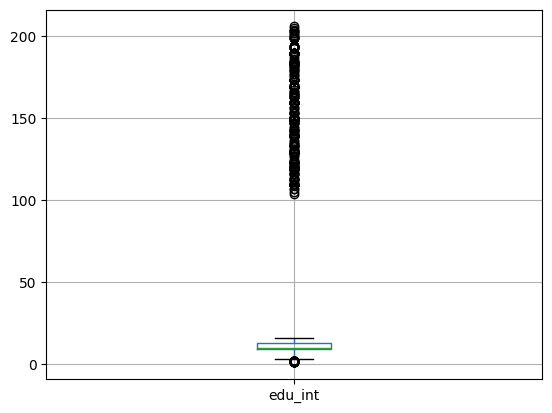

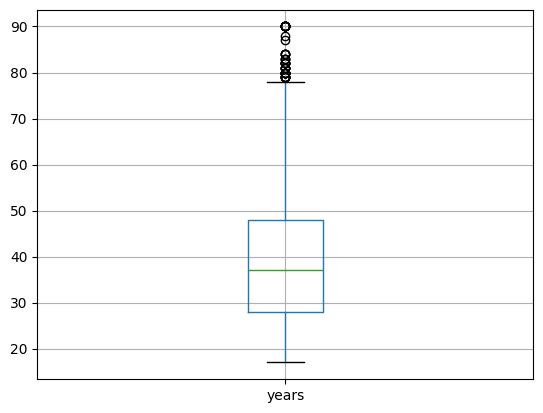

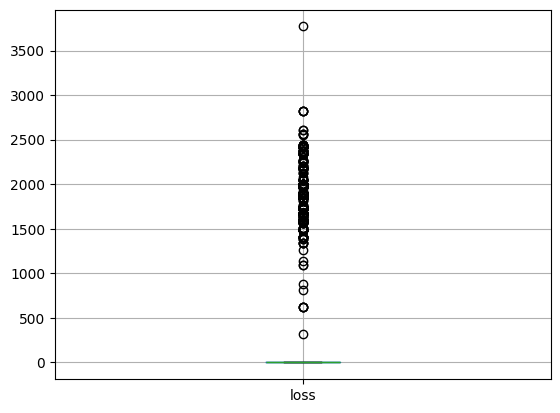

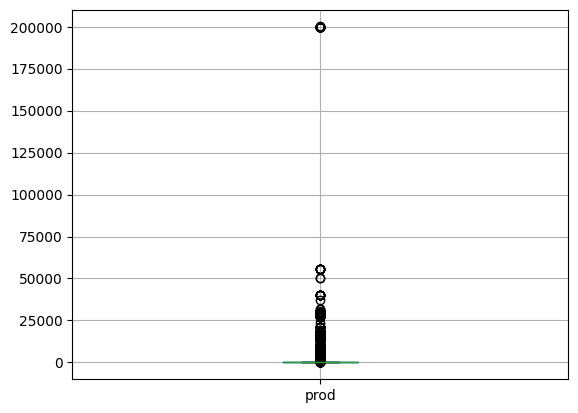

In [697]:
if CHOSEN_DATA == AVC_DATA:
    analyze_numeric_attributes(df_avc_prediction_full, continuous_columns_avc)
else:
    analyze_numeric_attributes(df_salary_classification_full, continuous_columns_salary)

#### Atribute numerice discrete sau ordinale

In [698]:
import matplotlib.pyplot as plt

def analyze_discrete_attributes(df, discrete_columns):    
    discrete_attributes = df[discrete_columns].describe().loc[['count']]

    for column in discrete_columns:
        if 'unique' in df[column].describe().index:
            discrete_attributes.loc['unique', column] = df[column].describe()['unique']
        else:
            unique_values = df[column].nunique()
            discrete_attributes.loc['unique', column] = unique_values
            
        if pd.isnull(discrete_attributes.loc['count', column]):
            count_values = df[column].count()
            discrete_attributes.loc['count', column] = count_values

    print (discrete_attributes)

    for column in discrete_columns:
        df[column].hist(width=0.1, bins=200)
        plt.tight_layout()
        plt.gcf().set_size_inches(20, 6)
        plt.xticks(rotation=30, ha='right')
        plt.title(column)
        plt.xlabel('Discrete Values')
        plt.ylabel('Frequency')
        plt.show()



       country   job work_type partner   edu gender  race gtype
count     9841  9417      9419    9999  9999   9199  9999  9999
unique      40    13         8       7    16      2     5     2


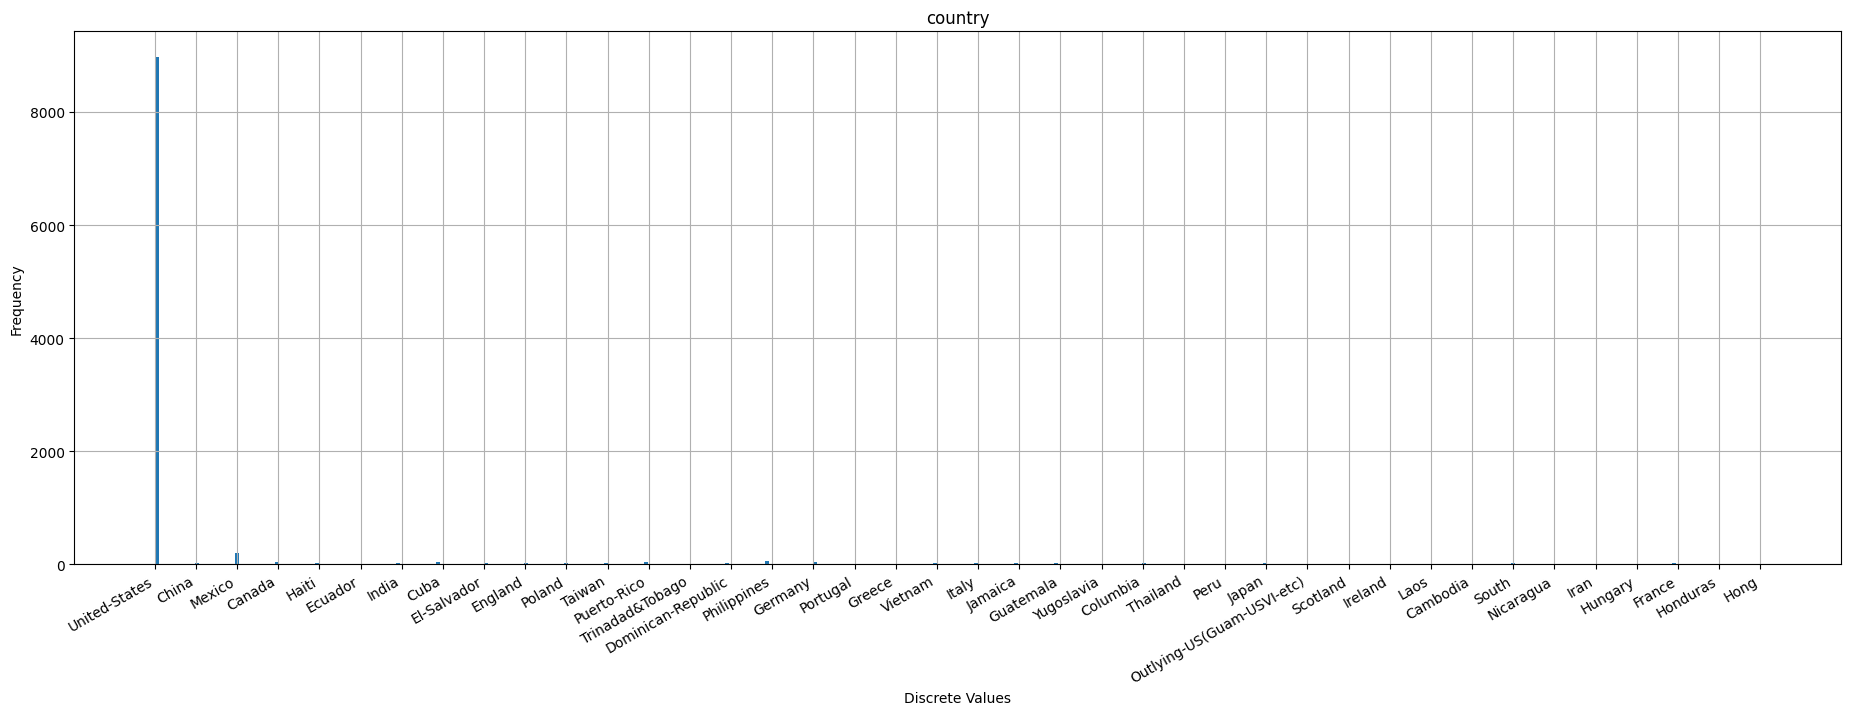

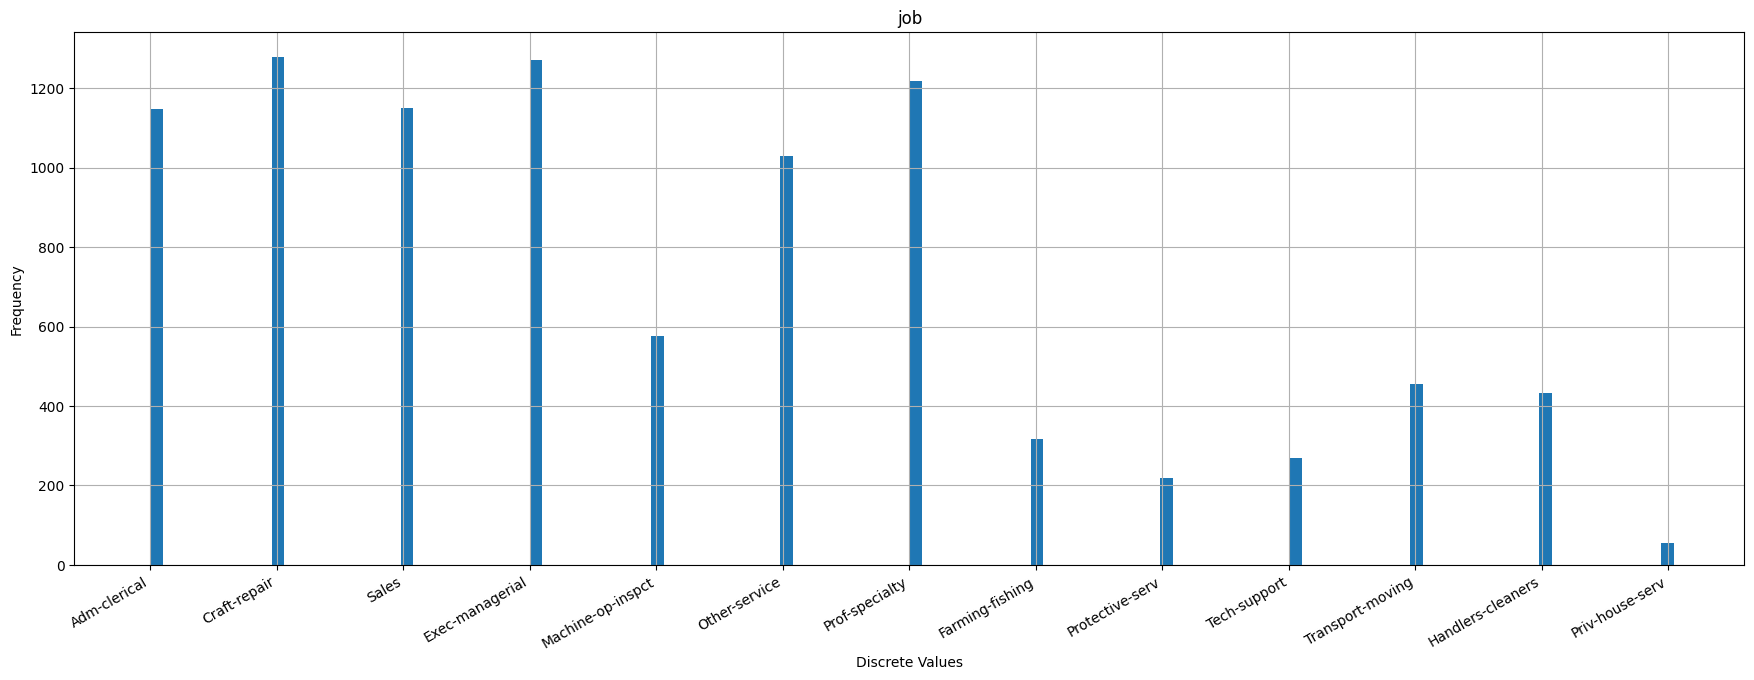

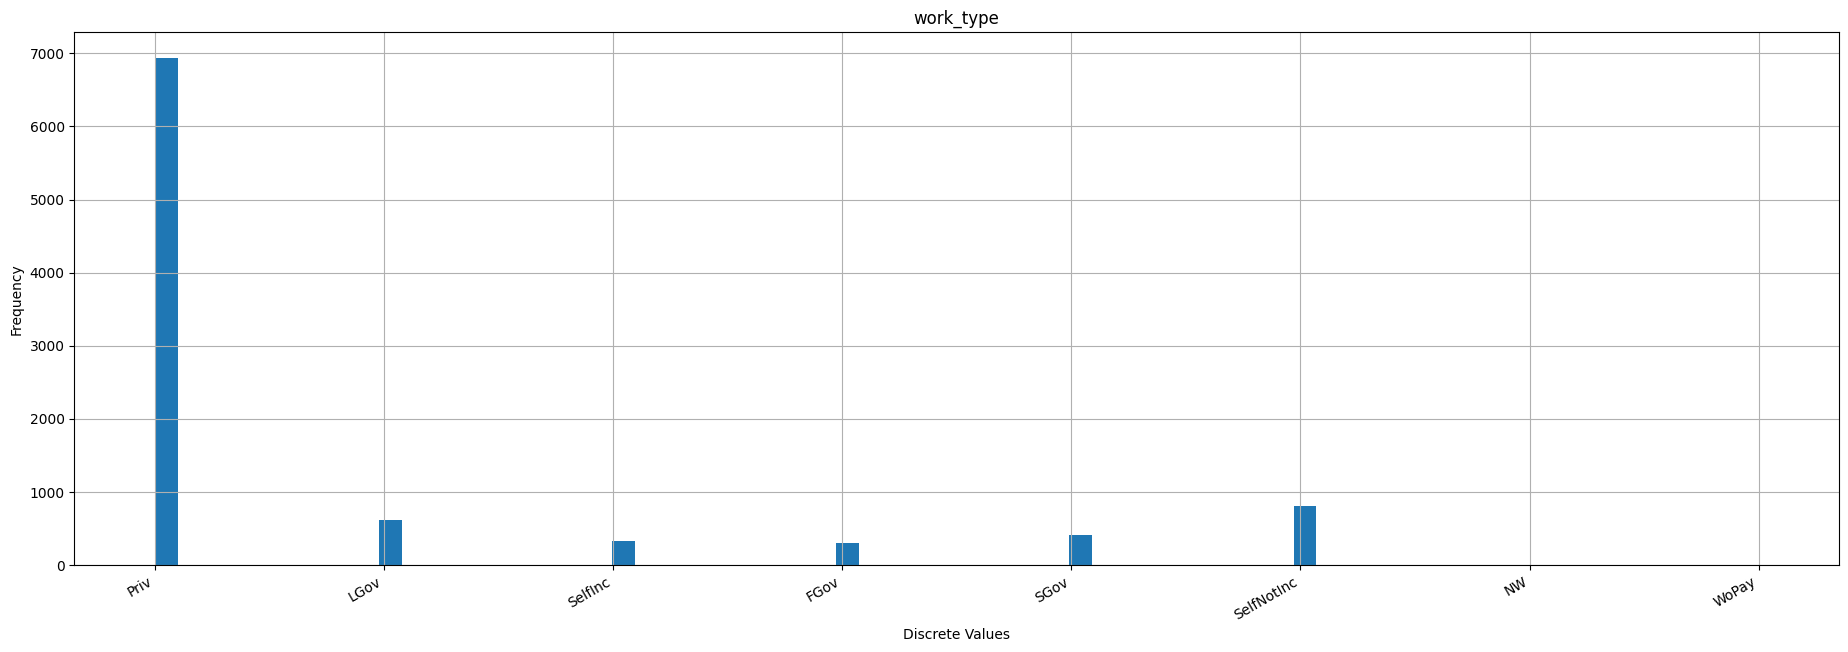

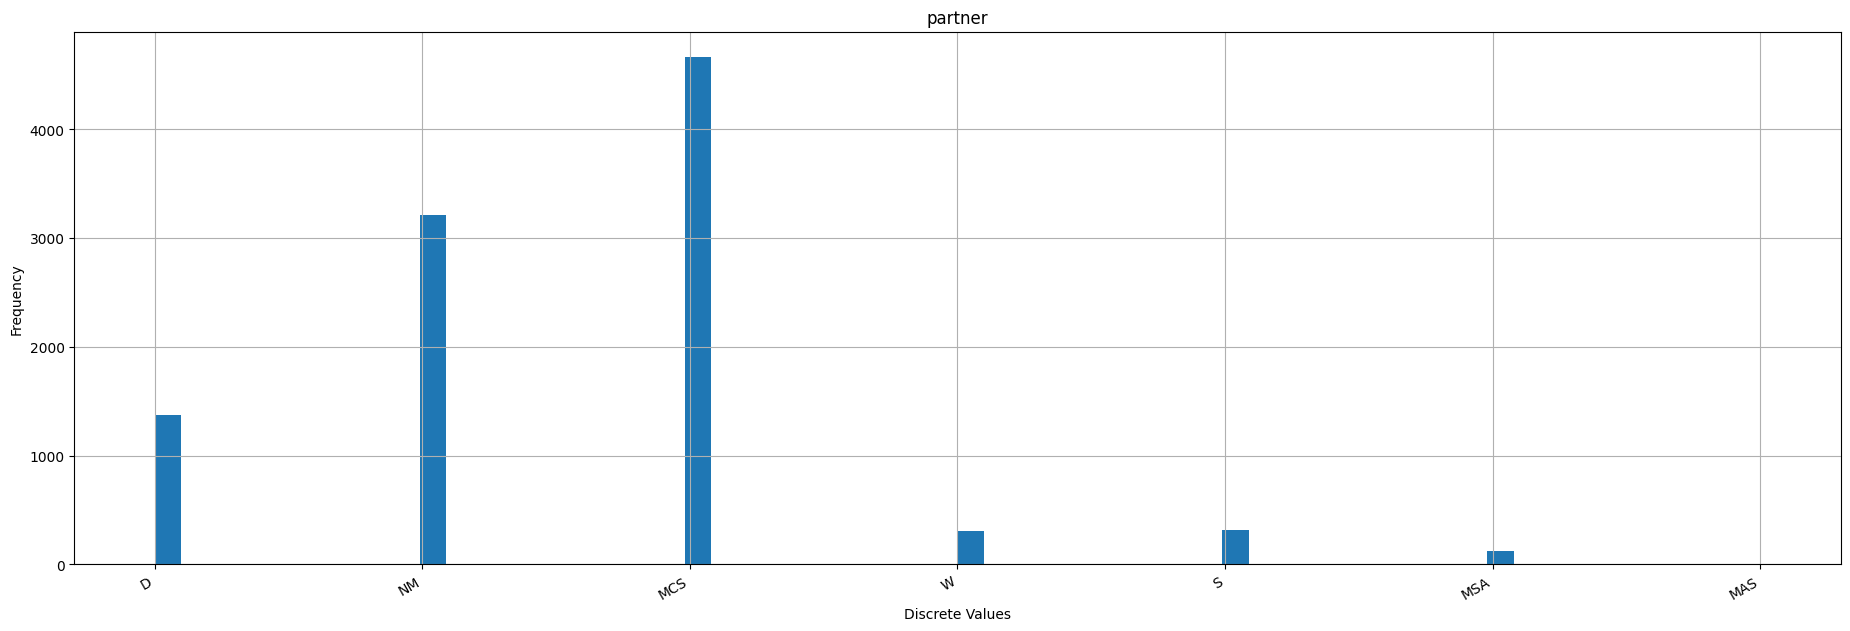

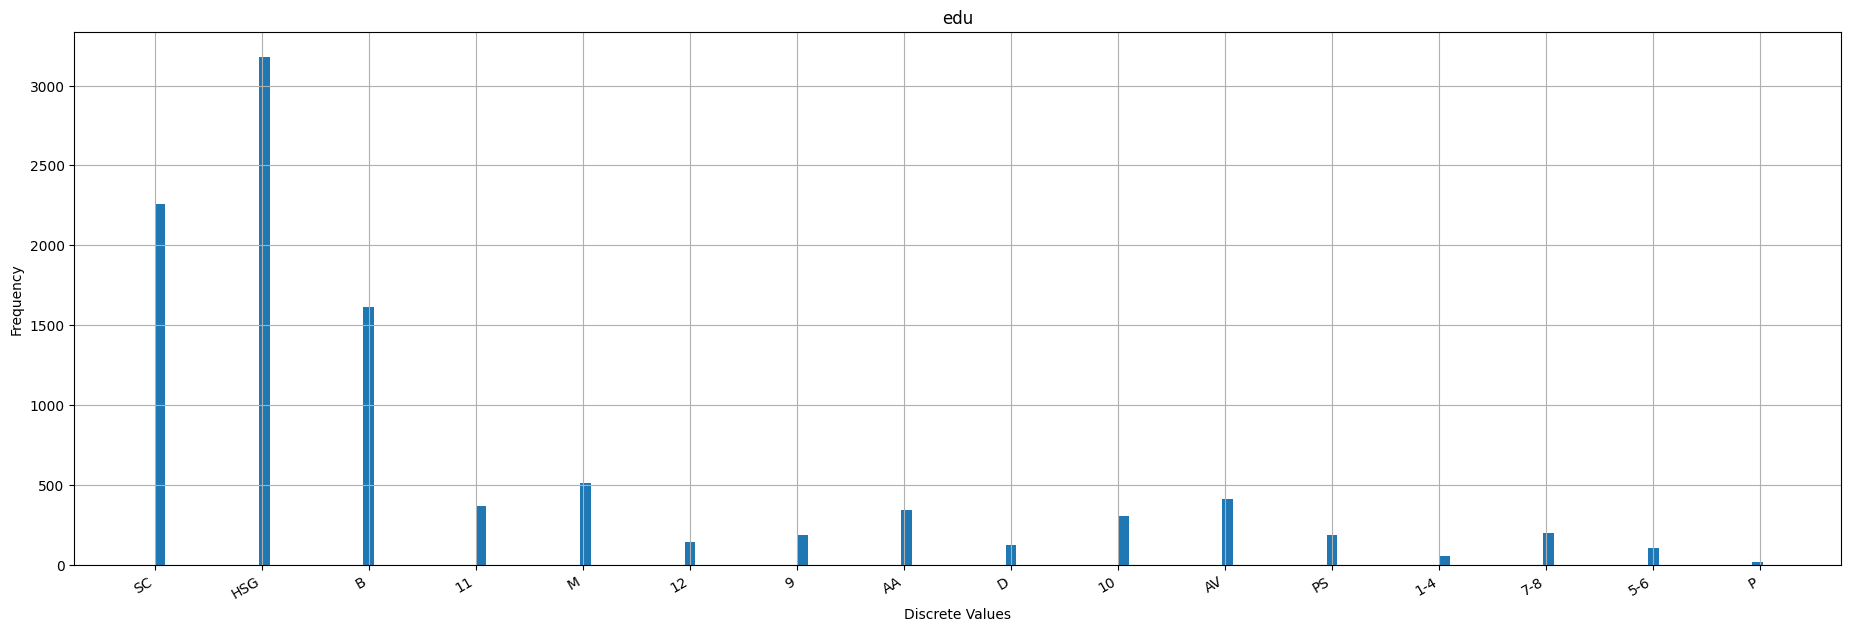

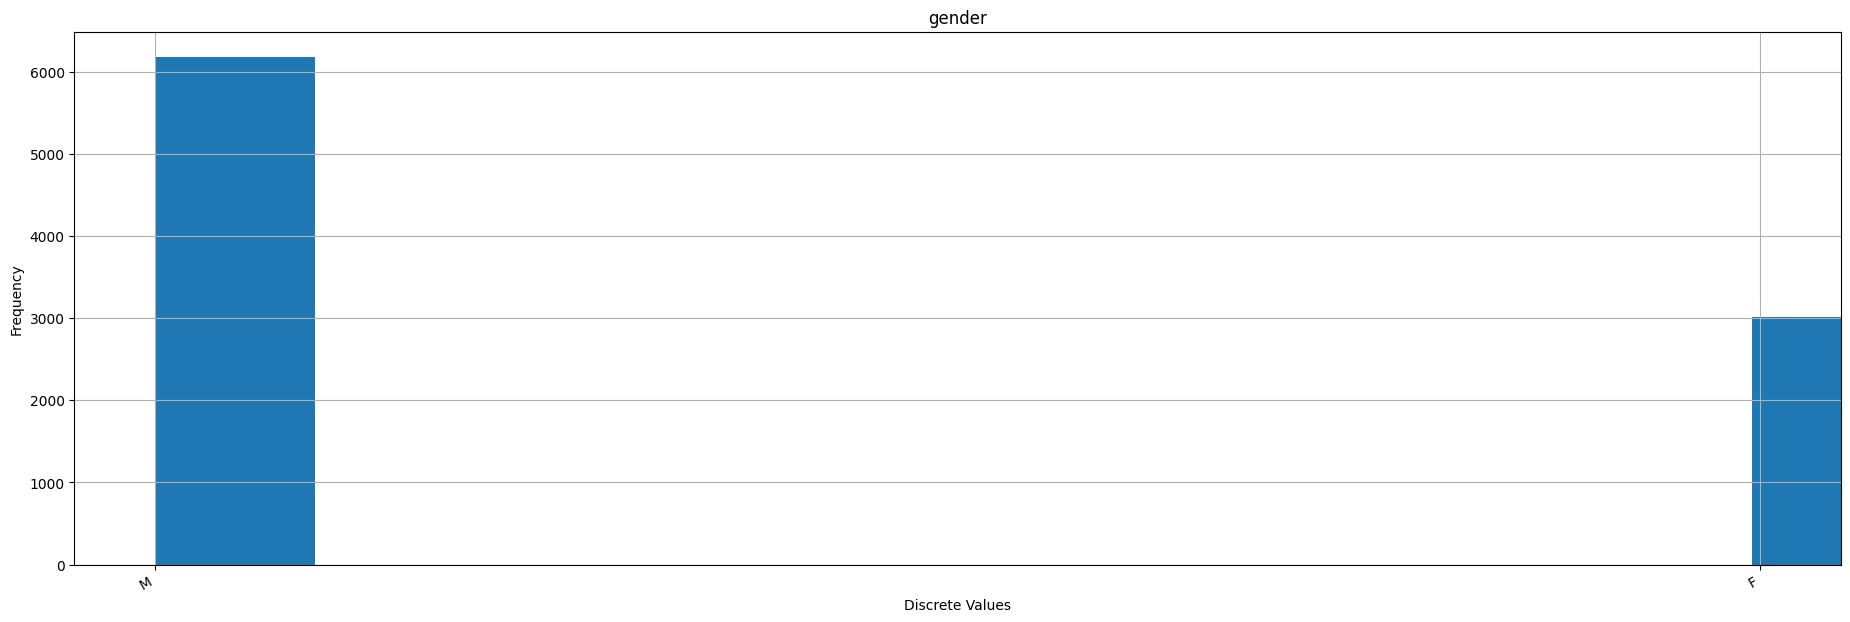

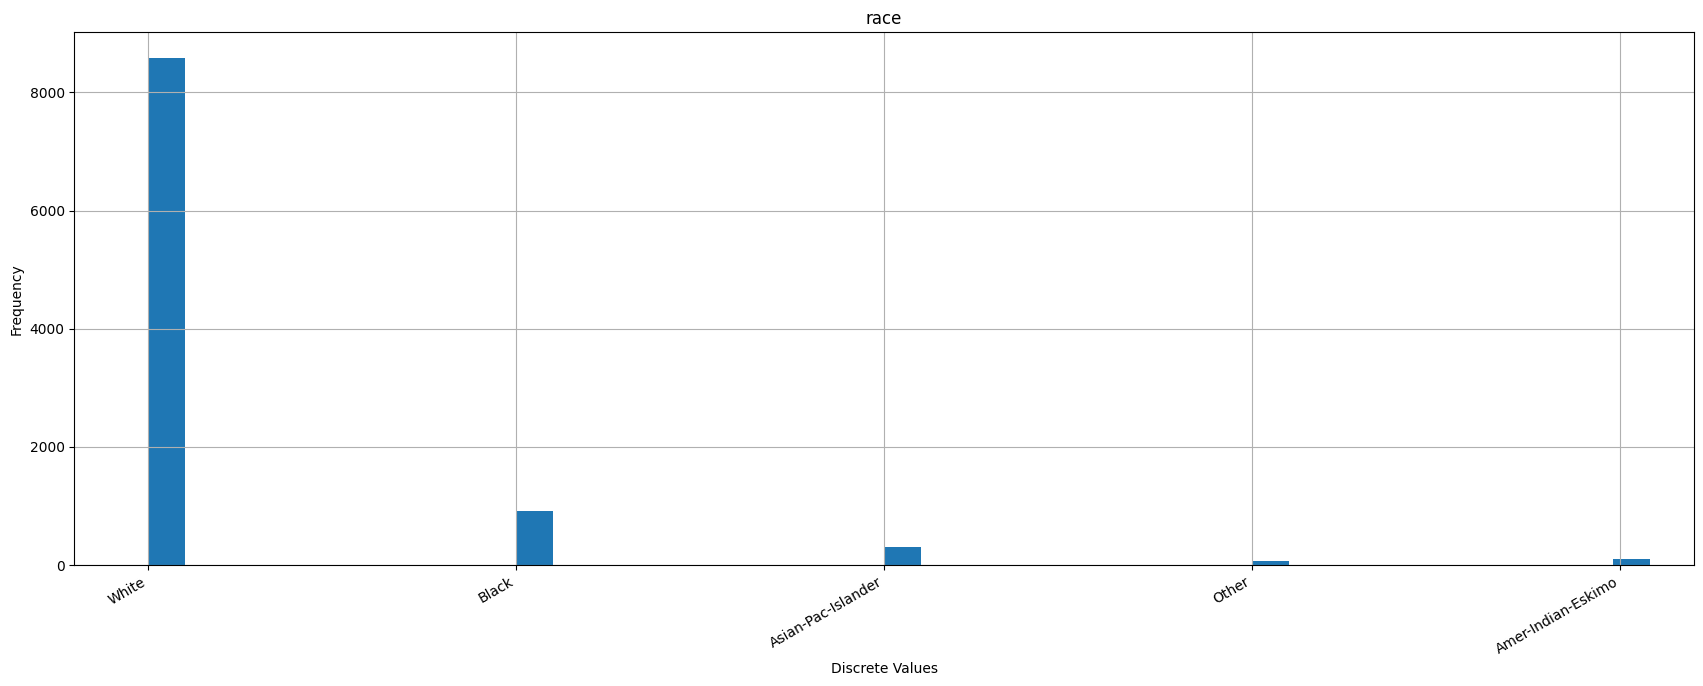

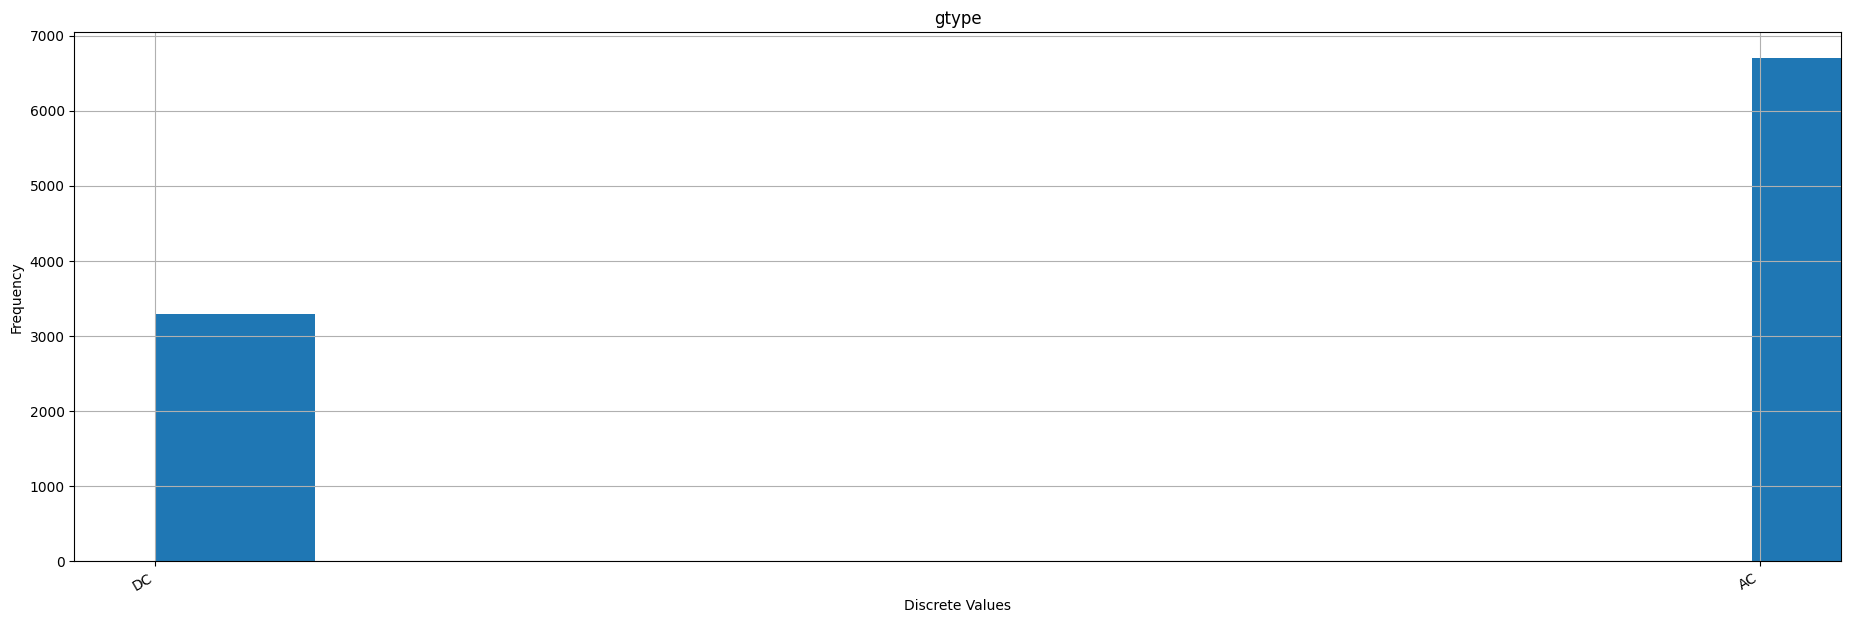

In [699]:
if CHOSEN_DATA == AVC_DATA:
    analyze_discrete_attributes(df_avc_prediction_full, discrete_columns_avc)
else:
    analyze_discrete_attributes(df_salary_classification_full, discrete_columns_salary)

### 2. Analiza echilibrului de clase

In [700]:
def analyze_equilibrum_labels(df_test, df_train, target_column):
    train_column_counts = df_train[target_column].value_counts()
    test_column_counts = df_test[target_column].value_counts()

    train_column_counts.plot(kind='bar', figsize=(20, 6), title=f'{target_column} in train dataset')
    plt.xlabel('Label')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.show()

    test_column_counts.plot(kind='bar', figsize=(20, 6), title=f'{target_column} in test dataset')
    plt.xlabel('Label')
    plt.xticks(rotation=30, ha='right')
    plt.ylabel('Frequency')
    plt.show()

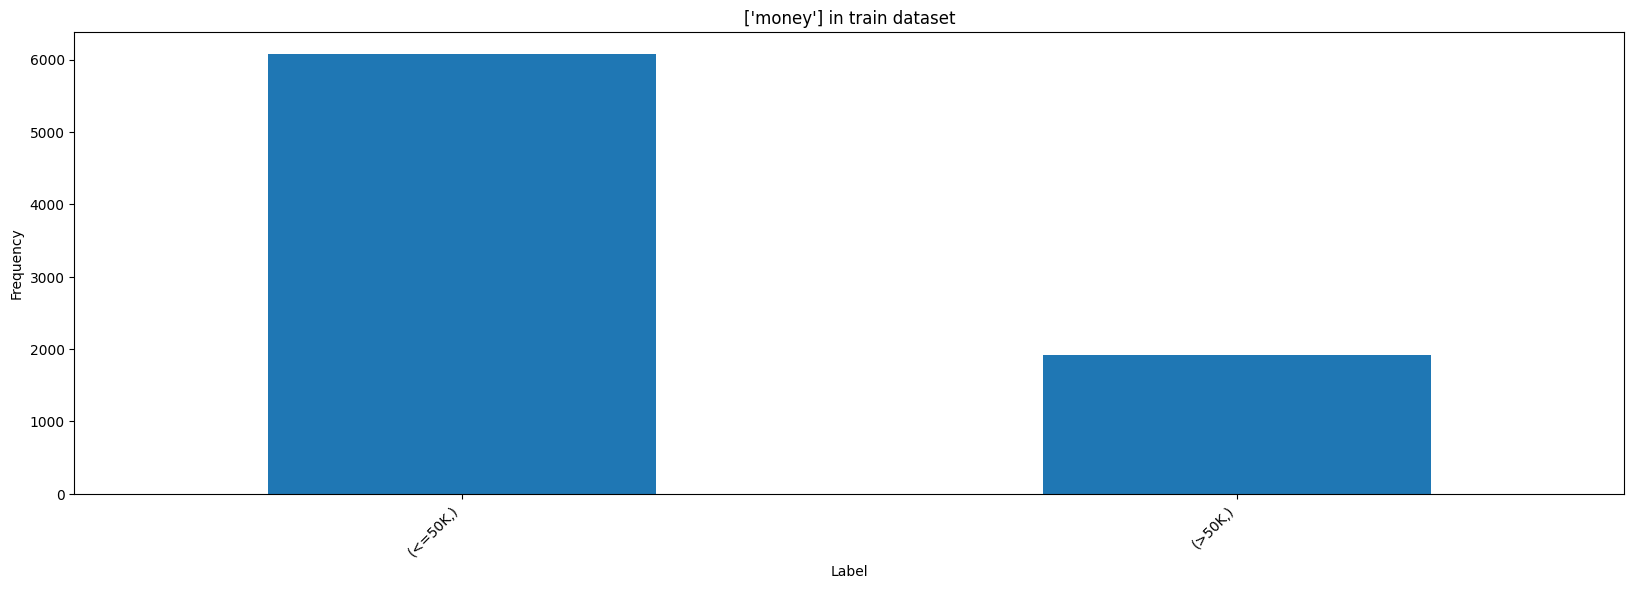

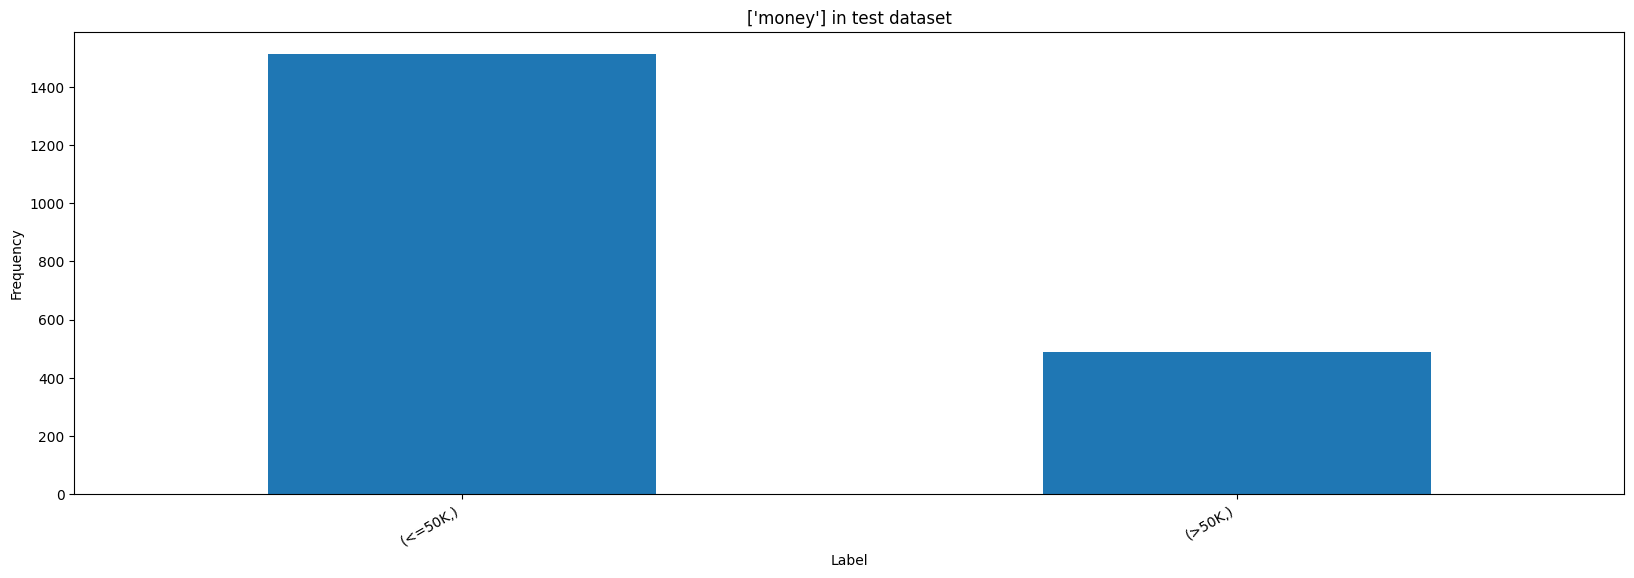

In [701]:
if CHOSEN_DATA == AVC_DATA:
    analyze_equilibrum_labels(df_avc_prediction_test, df_avc_prediction_train, target_column_avc)
else:
    analyze_equilibrum_labels(df_salary_classification_test, df_salary_classification_train, target_column_salary)

### 3. Analiza corelației de atribute

#### Atribute numerice continue

In [702]:
def analyze_continuous_correlation(df, continuous_columns):
    correlations = df[continuous_columns].corr()

    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111)

    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap='Greys')

    ticks = np.arange(len(continuous_columns))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(continuous_columns, rotation=90)
    ax.set_yticklabels(continuous_columns)

    fig.colorbar(cax)

    plt.show()


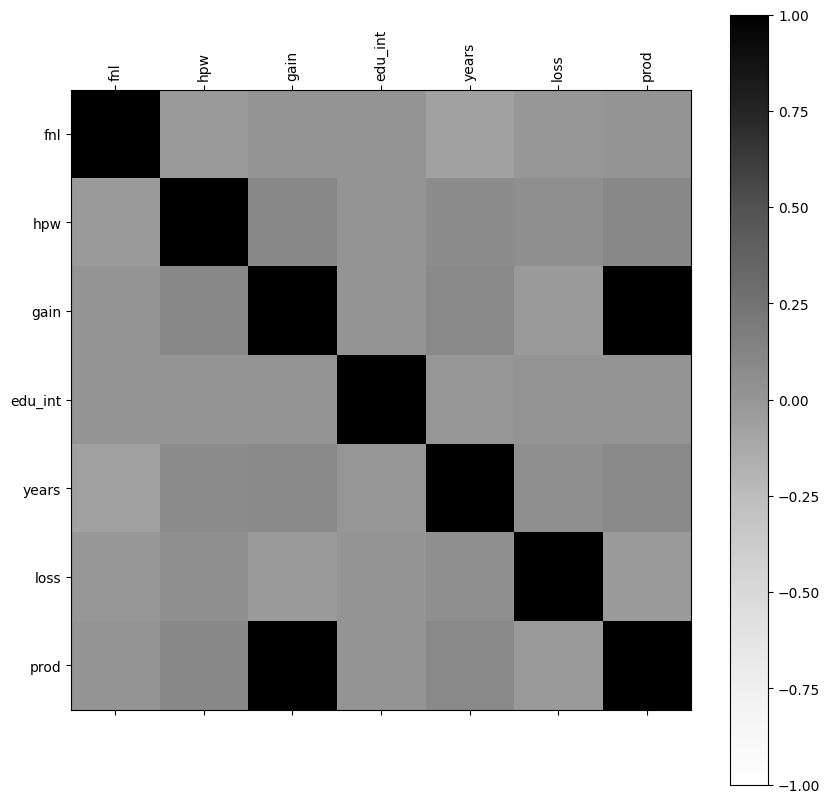

In [703]:
if CHOSEN_DATA == AVC_DATA:
    analyze_continuous_correlation(df_avc_prediction_train, continuous_columns_avc)
else:
    analyze_continuous_correlation(df_salary_classification_train, continuous_columns_salary)

#### Atribute numerice discrete sau ordinale

In [704]:
def analyze_discrete_correlation(df, discrete_columns):
    p_values_matrix = np.zeros((len(discrete_columns), len(discrete_columns)))

    for i, column1 in enumerate(discrete_columns):
        for j, column2 in enumerate(discrete_columns):
            if column1 == column2:
                p_values_matrix[i, j] = np.nan
                continue

            crosstable_result = pd.crosstab(index=df[column1], columns=df[column2])
            chi_sq_result = chi2_contingency(crosstable_result)
            p_values_matrix[i, j] = chi_sq_result[1]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    cax = ax.matshow(p_values_matrix, vmin=0, vmax=1, cmap='Greys')
    ticks = np.arange(len(discrete_columns))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(discrete_columns, rotation=90)
    ax.set_yticklabels(discrete_columns)

    fig.colorbar(cax)

    plt.show()


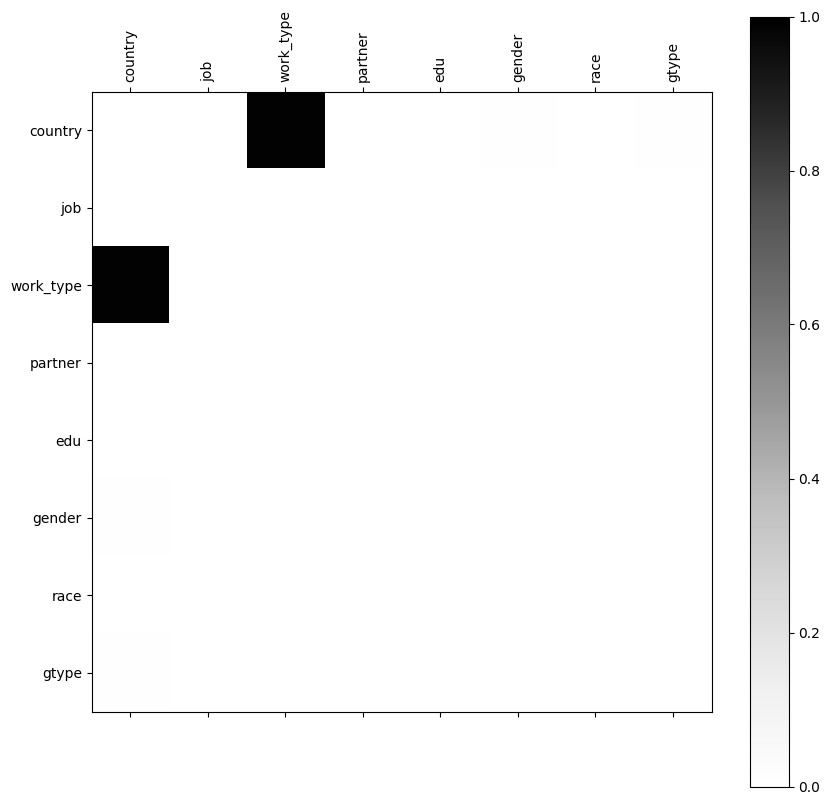

In [705]:
if CHOSEN_DATA == AVC_DATA:
    analyze_discrete_correlation(df_avc_prediction_train, discrete_columns_avc)
else:
    analyze_discrete_correlation(df_salary_classification_train, discrete_columns_salary)

## 3.2 Preprocesarea Datelor

### 1. Date lipsă pentru un atribut într-un eșantion

In [706]:
def data_imputation(df_train, df_test, continuous_columns, discrete_columns):
    imp_continuous = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_discrete = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    df_train[continuous_columns] = imp_continuous.fit_transform(df_train[continuous_columns])
    df_train[discrete_columns] = imp_discrete.fit_transform(df_train[discrete_columns])
 
    df_test[continuous_columns] = imp_continuous.transform(df_test[continuous_columns])
    df_test[discrete_columns] = imp_discrete.transform(df_test[discrete_columns])


In [707]:
if CHOSEN_DATA == AVC_DATA:
    data_imputation(df_avc_prediction_train, df_avc_prediction_test, continuous_columns_avc, discrete_columns_avc)
else:
    data_imputation(df_salary_classification_train, df_salary_classification_test, continuous_columns_salary, discrete_columns_salary)

### 2. Valori extreme pentru un atribut într-un eșantion

In [708]:
def outliers_replacement(df, continuous_columns):
    for column in continuous_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        IQR = Q3 - Q1

        threshold = 1.5

        if column in ['loss', 'gain']:
            df.loc[(df[column] < Q1) | (df[column] > Q3 + 1.0 * IQR), column] = np.nan
            continue

        df.loc[(df[column] < Q1 - threshold * IQR) | (df[column] > Q3 + threshold * IQR), column] = np.nan


In [709]:
if CHOSEN_DATA == AVC_DATA:
    outliers_replacement(df_avc_prediction_train, continuous_columns_avc)
    outliers_replacement(df_avc_prediction_test, continuous_columns_avc)
    data_imputation(df_avc_prediction_train, df_avc_prediction_test, continuous_columns_avc, discrete_columns_avc)
else:
    outliers_replacement(df_salary_classification_train, continuous_columns_salary)
    outliers_replacement(df_salary_classification_test, continuous_columns_salary)
    data_imputation(df_salary_classification_train, df_salary_classification_test, continuous_columns_salary, discrete_columns_salary)

### 3. Atribute redundante

In [710]:
df_salary_classification_train.drop(columns=['prod'], inplace=True)
df_salary_classification_test.drop(columns=['prod'], inplace=True)

df_avc_prediction_train.drop(columns=['mean_blood_sugar_level'], inplace=True)
df_avc_prediction_test.drop(columns=['mean_blood_sugar_level'], inplace=True)

if 'mean_blood_sugar_level' in continuous_columns_avc:
    continuous_columns_avc.remove('mean_blood_sugar_level')

if 'prod' in continuous_columns_salary:
    continuous_columns_salary.remove('prod')

### 4. Plaje valorice de mărimi diferite pentru atributele numerice

In [711]:
def data_standardization(df_train, df_test, continuos_columns):
    scaler_train = sklearn.preprocessing.StandardScaler().fit(df_train[continuos_columns])
    df_train[continuos_columns] = scaler_train.transform(df_train[continuos_columns])

    scaler_test = sklearn.preprocessing.StandardScaler().fit(df_test[continuos_columns])
    df_test[continuos_columns] = scaler_test.transform(df_test[continuos_columns])


In [712]:
if CHOSEN_DATA == AVC_DATA:
    data_standardization(df_avc_prediction_train, df_avc_prediction_test, continuous_columns_avc)
else:
    data_standardization(df_salary_classification_train, df_salary_classification_test, continuous_columns_salary)

## 3.3 Utilizarea algoritmilor de Învățare Automată

### Regresie logică

In [713]:
def encode_discrete(df_train, df_test, target_column):
    df_train_encoded = pd.get_dummies(df_train)
    df_test_encoded = pd.get_dummies(df_test)

    df_train_encoded = df_train_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)
    df_train_encoded.drop(df_train_encoded.columns.difference(df_test_encoded.columns), axis=1, inplace=True)

    df_test_encoded = df_test_encoded.reindex(columns=df_test_encoded.columns, fill_value=0)
    df_test_encoded.drop(df_test_encoded.columns.difference(df_train_encoded.columns), axis=1, inplace=True)

    return df_train_encoded, df_test_encoded


In [714]:
from sklearn.preprocessing import MinMaxScaler

if CHOSEN_DATA == AVC_DATA:
    df_avc_prediction_train_encoded, df_avc_prediction_test_encoded = encode_discrete(df_avc_prediction_train, df_avc_prediction_test, target_column_avc)
else:
    df_salary_prediction_train_encoded, df_salary_prediction_test_encoded = encode_discrete(df_salary_classification_train, df_salary_classification_test, target_column_salary)


#### 1. Implementare manuală

In [715]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    fig, (ax1, ax2) = plt.subplots(2,1)

    # Afisam cu verde acuratetea pe setul de antrenare si cu rosu acuratetea pe setul de testare
    ax1.plot(range(epochs_no), train_acc, label="Train Accuracy", color="green")
    ax1.plot(range(epochs_no), test_acc, label="Test Accuracy", color="red")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Afisam cu verde NLL pe setul de antrenare si cu rosu NLL pe setul de testare
    ax2.plot(range(epochs_no), train_nll, label="Train NLL", color="green")
    ax2.plot(range(epochs_no), test_nll, label="Test NLL", color="red")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)
    
    plt.show()

In [716]:
def visualize_dataset(X, T, Y=None, w=None, other_w=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    if w is not None:
        __x = np.linspace(0, 1, 100)
        __y = -w[0] / w[1] * __x - w[2] / w[1]
        plt.plot(__x, __y, color="black")

    if other_w is not None:
        __x = np.linspace(0, 1, 100)
        __y = -other_w[0] / other_w[1] * __x - other_w[2] / other_w[1]
        plt.plot(__x, __y, color="orange")

    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.show()

In [717]:
def nll(Y, T):
    N = T.shape[0]
    return - 1 / N * np.sum(np.where(T == 1, np.log(Y), np.log(1 - Y)))

In [718]:
def logistic(x):
    return np.array(1 / (np.array(1 + np.exp(-np.float32(x)))))

In [719]:
def accuracy(Y, T):
    N = Y.shape[0]

    # Ensure Y and T are 1D arrays for logical operations
    Y = Y.flatten()
    T = T.flatten()

    condition_1 = np.logical_and(T == 1, Y >= 0.5)
    condition_2 = np.logical_and(T == 0, Y < 0.5)

    correct_predictions = np.sum(np.logical_or(condition_1, condition_2))

    # Return the accuracy as a proportion
    return correct_predictions / N

In [720]:
def predict_logistic(X, w):
    return logistic(np.dot(X, w))

In [721]:
def train_and_eval_logistic(X, X_train, T_train, X_test, T_test, lr=.01, epochs_no=100):
    (N, D) = X.shape
    
    w = np.random.randn(D)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []

    for epoch in range(epochs_no):
        Y_train = predict_logistic(X_train, w)
        
        Y_test = predict_logistic(X_test, w)

        train_acc.append(accuracy(Y_train, T_train))    
        test_acc.append(accuracy(Y_test, T_test))

        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        
        w = w - 1 / N * np.dot(X_train.T, (Y_train - np.squeeze(T_train)))

        
    return w, train_nll, test_nll, train_acc, test_acc

In [722]:
from sklearn.metrics import confusion_matrix

def logistic_regression_manual(df_train, df_test, remove_columns, target_column):
    N_EPOCHS = 500

    X_train = df_train.drop(columns=remove_columns)
    X_test = df_test.drop(columns=remove_columns)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)
    
    X = df_train.drop(columns=remove_columns).to_numpy()
    T_train = df_train[target_column].to_numpy()
    T_test = df_test[target_column].to_numpy()

    
    # Adaugăm o coloană de 1-uri pentru bias in setul de date X
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    X_train_scaled = np.concatenate([X_train, np.ones((X_train.shape[0], 1))], axis=1)
    X_test_scaled = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)

    w, train_nll, test_nll, train_acc, test_acc = train_and_eval_logistic(X, X_train_scaled, T_train, X_test_scaled, T_test, lr=0.1, epochs_no=N_EPOCHS)
    
    Y = predict_logistic(X_test_scaled, w)

    Y_pred = [1 if y >= 0.5 else 0 for y in Y] 

    cr = classification_report(T_test, Y_pred)
    cm = confusion_matrix(T_test, Y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'False'])
    disp.plot()
    plt.show()

    print(f"Accuracy: {test_acc[-1]}")
    print (cr)


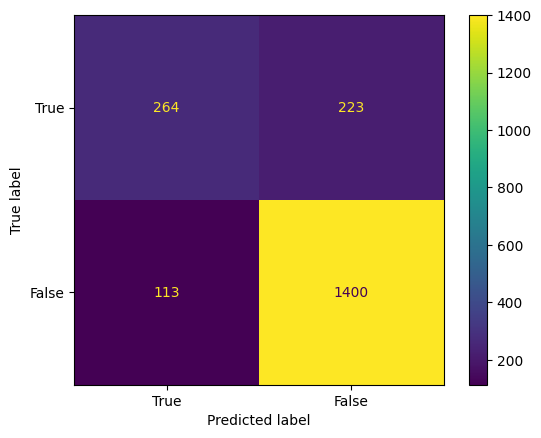

Accuracy: 0.832
              precision    recall  f1-score   support

       False       0.70      0.54      0.61       487
        True       0.86      0.93      0.89      1513

    accuracy                           0.83      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.82      0.83      0.82      2000



In [723]:
if CHOSEN_DATA == AVC_DATA:
    X = df_avc_prediction_train_encoded.to_numpy()
    logistic_regression_manual(df_avc_prediction_train_encoded, df_avc_prediction_test_encoded, remove_columns_avc_regression, target_column_avc_algorithms)
else:
    X = df_salary_prediction_train_encoded.to_numpy()
    logistic_regression_manual(df_salary_prediction_train_encoded, df_salary_prediction_test_encoded, remove_columns_salary_regression, target_column_salary_algorithms)

#### 2. Implementare folosind biblioteca scikit-learn

In [724]:
def logistic_regression_scikit(df_train, df_test, remove_columns, target_column):
    model = sklearn.linear_model.LogisticRegression(class_weight='balanced', solver='saga', penalty='elasticnet', l1_ratio=0.8)

    X_train = df_train.drop(columns=remove_columns)
    X_test = df_test.drop(columns=remove_columns)
    
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot()
    plt.show()


C:\Users\LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.787
Confusion Matrix:
[[ 407   80]
 [ 346 1167]]
Classification Report:
              precision    recall  f1-score   support

       False       0.54      0.84      0.66       487
        True       0.94      0.77      0.85      1513

    accuracy                           0.79      2000
   macro avg       0.74      0.80      0.75      2000
weighted avg       0.84      0.79      0.80      2000



C:\Users\LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


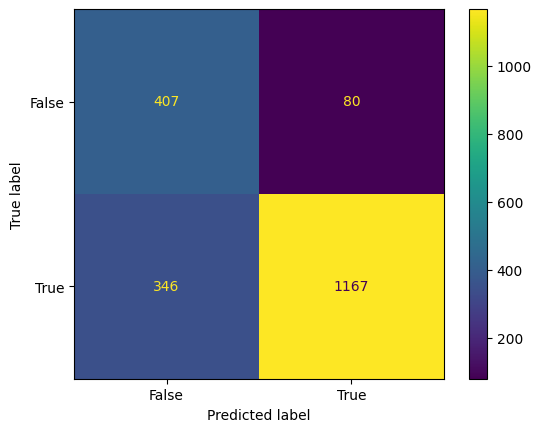

In [725]:
if CHOSEN_DATA == AVC_DATA:
    logistic_regression_scikit(df_avc_prediction_train_encoded, df_avc_prediction_test_encoded, remove_columns_avc_regression, target_column_avc_algorithms)
else:
    logistic_regression_scikit(df_salary_prediction_train_encoded, df_salary_prediction_test_encoded, remove_columns_salary_regression, target_column_salary_algorithms)

### Multi-Layered Perceptron (MLP)

#### 1. Implementare manuală

In [726]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass

In [727]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
   
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        self.dweight = np.dot(self.x.T, dy)
        self.dbias = np.sum(dy, axis=0)
        return np.dot(dy, self.weight.T)
    
    def update(self, mode='SGD', lr=0.001, mu=0.9):
        if mode == 'SGD':
            self.weight = self.weight - lr * self.dweight
            self.bias = self.bias - lr * self.dbias
        else:
            raise ValueError('mode should be SGD, not ' + str(mode))

In [728]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        return dy * (x > 0)

In [729]:
class CrossEntropy:
    
    def __init__(self):
        pass
    
    def softmax(self, x):
        exps = np.exp(np.float64(x))
        return exps / np.sum(exps,axis = 1).reshape(-1,1)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        self.y = y
        self.t = t
        self.p = self.softmax(y)
        return -np.mean(np.log(self.p[np.arange(len(t)), t]))
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        self.p = self.softmax(y)
        self.p[np.arange(len(t)), t] -= 1
        return self.p / len(t)


In [730]:
class L2CrossEntropy(CrossEntropy):
  def __init__(self, lam: float = 0.0):
    super().__init__()
    self.lam = lam

  def forward(self, y: np.ndarray, t: np.ndarray) -> float:
    self.y = y
    self.t = t
    self.p = self.softmax(y)
    loss = -np.mean(np.log(self.p[np.arange(len(t)), t]))

    l2_reg = self.lam * 0.5 * np.sum(self.y ** 2)

    return loss + l2_reg

  def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
    self.p = self.softmax(y)
    self.p[np.arange(len(t)), t] -= 1
    grad = self.p / len(t)

    grad = grad + self.lam * self.y

    return grad

In [731]:
def accuracy_mlp(y: np.ndarray, t: np.ndarray) -> float:
    return np.mean(np.argmax(y, axis=1) == t)

In [732]:
from typing import List


class FeedForwardNetwork:
    
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy: np.ndarray) -> np.ndarray:
        for x, layer in zip(reversed(self._inputs), reversed(self.layers)):
            dy = layer.backward(x, dy)
        del self._inputs
        
        return dy
    
    
    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

In [733]:
def mlp_classifier_manual(df_train, df_test, remove_columns, target_column, epochs_no, batch_size, hidden_units, reshape_size, learning_rate, l2_lambda):
    optimize_args = {'mode': 'SGD', 'lr': learning_rate}
    
    net = FeedForwardNetwork([Linear(reshape_size, hidden_units),
                            ReLU(),
                            Linear(hidden_units, 2)])
    cost_function = L2CrossEntropy(l2_lambda)

    train_imgs = df_train.drop(columns=remove_columns)
    test_imgs = df_test.drop(columns=remove_columns)

    train_labels = df_train[target_column]
    test_labels = df_test[target_column]

    train_labels = train_labels.astype(int)
    test_labels = test_labels.astype(int)

    train_acc_array = []
    test_acc_array = []
    train_nll_array = []
    test_nll_array = []

    for epoch in range(epochs_no):
        for b_no, start_idx  in enumerate(range(0, train_imgs.shape[0], batch_size)):
            end_idx = min(start_idx + batch_size, train_imgs.shape[0])
    
            x = train_imgs.iloc[start_idx:end_idx, :].values.reshape(-1, reshape_size)
            t = train_labels.iloc[start_idx:end_idx].values
            t = t.astype(int)
            
            y = net.forward(x)
            loss = cost_function.forward(y, t)
            dy = cost_function.backward(y, t)
            net.backward(dy)
            
            net.update(**optimize_args)
            
            print(f'\rEpoch {epoch + 1:02d} '
                f'| Batch {b_no:03d} '
                f'| Train NLL: {loss:6.3f} '
                f'| Train Acc: {accuracy_mlp(y, t) * 100:6.2f}% ', end='')

        y = net.forward(test_imgs.values.reshape(-1, reshape_size), train=False)
        test_nll = cost_function.forward(y, test_labels)
        print(f'| Test NLL: {test_nll:6.3f} '
            f'| Test Acc: {accuracy_mlp(y, test_labels.values) * 100:3.2f}%')
        
        train_acc_array.append(accuracy_mlp(y, t) * 100)
        test_acc_array.append(accuracy_mlp(y, test_labels.values) * 100)
        train_nll_array.append(loss)
        test_nll_array.append(test_nll)

        if epoch == epochs_no - 1:
            y_pred = np.argmax(y, axis=1)

            cr = classification_report(test_labels, y_pred)
            cm = confusion_matrix(test_labels, y_pred)

            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'False'])
            disp.plot()
            plt.show()
            print ("Accuracy: " + str(accuracy_mlp(y, test_labels.values)))
            print(cr)

    plot_evolution(train_acc_array, test_acc_array, train_nll_array, test_nll_array)


Epoch 01 | Batch 015 | Train NLL:  2.087 | Train Acc:  58.72% | Test NLL:  7.802 | Test Acc: 59.82%
Epoch 02 | Batch 015 | Train NLL:  1.455 | Train Acc:  59.49% | Test NLL:  4.793 | Test Acc: 61.23%
Epoch 03 | Batch 015 | Train NLL:  1.207 | Train Acc:  59.03% | Test NLL:  3.552 | Test Acc: 60.49%
Epoch 04 | Batch 015 | Train NLL:  1.066 | Train Acc:  59.03% | Test NLL:  2.841 | Test Acc: 60.54%
Epoch 05 | Batch 015 | Train NLL:  0.978 | Train Acc:  59.64% | Test NLL:  2.391 | Test Acc: 60.88%
Epoch 06 | Batch 015 | Train NLL:  0.920 | Train Acc:  60.26% | Test NLL:  2.086 | Test Acc: 61.11%
Epoch 07 | Batch 015 | Train NLL:  0.879 | Train Acc:  60.26% | Test NLL:  1.868 | Test Acc: 61.57%
Epoch 08 | Batch 015 | Train NLL:  0.848 | Train Acc:  60.41% | Test NLL:  1.702 | Test Acc: 61.82%
Epoch 09 | Batch 015 | Train NLL:  0.825 | Train Acc:  60.88% | Test NLL:  1.574 | Test Acc: 62.34%
Epoch 10 | Batch 015 | Train NLL:  0.806 | Train Acc:  61.49% | Test NLL:  1.472 | Test Acc: 62.75%


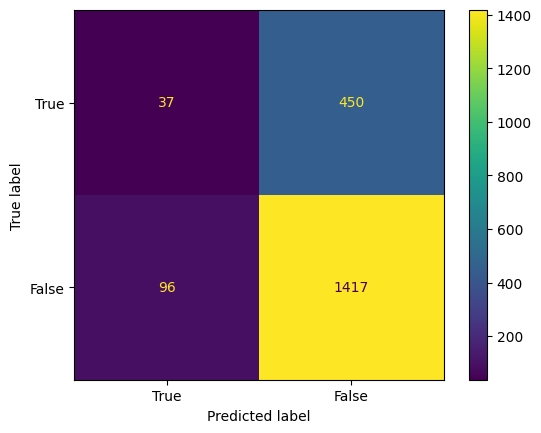

Accuracy: 0.7223855
              precision    recall  f1-score   support

           0       0.28      0.08      0.12       487
           1       0.76      0.94      0.84      1513

    accuracy                           0.73      2000
   macro avg       0.52      0.51      0.48      2000
weighted avg       0.64      0.73      0.66      2000



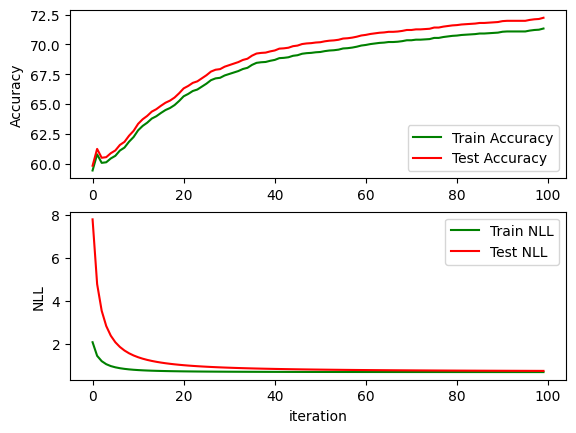

In [738]:
if CHOSEN_DATA == AVC_DATA:
    mlp_classifier_manual(df_avc_prediction_train_encoded, df_avc_prediction_test_encoded, remove_columns_avc_regression, target_column_avc_algorithms, epochs_no_avc, batch_size_avc, hidden_units_avc, resize_size_avc, learning_rate_avc, l2_lambda_avc)
else:
    mlp_classifier_manual(df_salary_prediction_train_encoded, df_salary_prediction_test_encoded, remove_columns_salary_regression, target_column_salary_algorithms, epochs_no_salary, batch_size_salary, hidden_units_salary, resize_size_salary, learning_rate_salary, l2_lambda_salary)

#### 2. Implementare folosind biblioteca scikit-learn

In [735]:
def mlp_classifier_scikit(df_train, df_test, remove_columns, target_column):
    model = MLPClassifier(solver='sgd', learning_rate='adaptive', learning_rate_init=0.01, 
                        max_iter=300, random_state=42, early_stopping=True)

    X_train = df_train.drop(columns=remove_columns)
    X_test = df_test.drop(columns=remove_columns)
    
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot()
    plt.show()

C:\Users\LEGION\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8365
Confusion Matrix:
[[ 264  223]
 [ 104 1409]]
Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.54      0.62       487
        True       0.86      0.93      0.90      1513

    accuracy                           0.84      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.83      0.84      0.83      2000



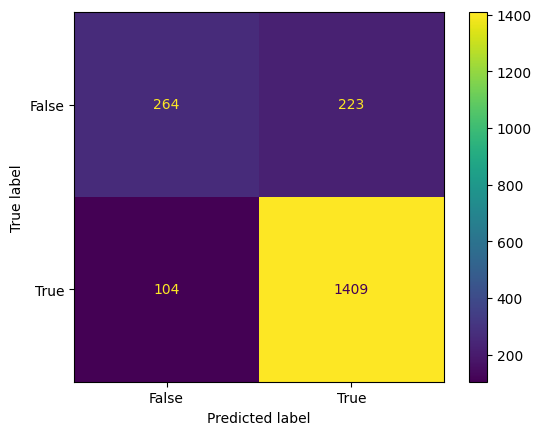

In [736]:
if CHOSEN_DATA == AVC_DATA:
    mlp_classifier_scikit(df_avc_prediction_train_encoded, df_avc_prediction_test_encoded, remove_columns_avc_regression, target_column_avc_algorithms)
else:
    mlp_classifier_scikit(df_salary_prediction_train_encoded, df_salary_prediction_test_encoded, remove_columns_salary_regression, target_column_salary_algorithms)